# Stock forecasting based on econonomic indicators

## Introduction to GARCH Modelling

(Generalized) autoregressive conditionally heteroskedastic (GARCH) models were created for econometric and financial problems due to the variant volatility in financial data over time. The GARCH (p,q) model is given by

(1) $Y_{t} = \zeta + \delta y_{t-1} + \theta u_{t-1}^{2}$

Where $Y_{t}$ denotes equity returns for day $t$. This equation describes equity terms in terms of previous returns (the autoregressive term) and the error resulting from a combination of white noise as well as the portion of returns not explained by the autoregressive term. As a result, the error term $u_t$ is given by: 

(2) $u_t = h_t e_t$ and $e_t$ ~ $N(0,1)$ and $I.I.D$ (a white noise process). 

$h_t$ is the part of the error term that we can explain away due to trends in the financial data and it is given by:  

(3) $h_t = \omega + \sum^{q}_{i=1} \alpha_i u_{t-1}  + \sum^{p}_{i=1} \beta_i h_{t-1}$

In the model specification, q denotes the number of autoregressive $u_t$ terms and p denotes the number of autoregressive $h_t$ terms. 

After the model is specified the parameters are learned using Maximum Likelihood Estimation (MLE) and the model is then evaluated based on the absense of autocorrelation in the error term $u_t$; if autocorreclation exists, then the model is ineffective in explaining all of the trens influencing equity returns. 

This project’s goal was to predict equity returns based on macroeconomic shocks such as changes in Gross Domestic Product (GDP), unemployment rates, sector stocks, among numerous others. The equity returns were modeled as a GARCH process. Equity returns $Y$ for stock $i$ at day $t$ are given by: 

(4) $Y_{i,t} = E_{t-1}(Y_{i,t}) + \sum^{N}_{n=1} \beta ^{i}_{n} [F_{nt} - E_{t}(F_{nt})] + u_{i,t}$

Equation (4) shows equity returns explained by previous returns, information on macroeconomic shocks, and an error term. 

(5) $E_{t-1}(Y_{i,t}) = Y^{i}_{0} + \delta^{i}_{1}Y_{i, t-1} + \delta^{i}_{ENDYR}ENDYR_{t} + \delta^{i}_{JAN}JAN_{t} + \delta^{i}_{MON}MON_{t} $

Equation (5) shows how the autoregressive term was modified to use $E_{t-1}(Y_{i,t})$ - this modification allows the model to account for portion of returns explained by macroeconomic effects, as well as financial effects such as spikes due to end-of-year, decreases due to the beginning of year, and data lag due to the Monday effect 

Just as in the original GARCH(1,1) model, the error term is given by:   

(6) $u_t = h_t e_t$ and $e_t$ ~ $N(0,1)$ and $I.I.D$

(7) $h_{i,t}^{2} = [h_{0}^{i} + \rho^{i}_{1} \frac{h_{i,t-1}^{2}}{\Gamma_{i,t-1}} + \theta^{i}_{1} u_{i, t-1}^{2}] * \Gamma_{i,t}$

(8) $\Gamma_{i,t} = exp[\sum^{N}_{n=1} \phi_{n} DF_{n,t}] $


Here is an example of the model being used to explain returns for the Consumer Staples Select Sector stock (XLP) using GDP: 

$XLP_{t} = E_{t-1}(XLP_{t}) + \beta ^{XLP}_{GDP} [F_{GDP,t} - E_{t}(F_{GDP,t})] + u_{i,t}$

The autoregressive term is given by
$E_{t-1}(XLP_{t}) = XLP_{0} + \delta^{i}_{ENDYR}ENDYR_{t} + \delta^{i}_{JAN}JAN_{t} + \delta^{i}_{MON}MON_{t} $

The error term is given by: 
$u_t = h_t e_t$

$h_{XLP,t}^{2} = [h_{0}^{XLP} + \rho^{XLP}_{1} \frac{h_{XLP,t-1}^{2}}{\Gamma_{XLP,t-1}} + \theta^{XLP}_{1} u_{XLP, t-1}^{2}] * \Gamma_{XLP,t}$

$\Gamma_{XLP,t} = exp[\phi_{XLP} DF_{XLP,t}] $

### Data collection

Publically available data was used for this project; equity returns were pulled from Yahoo! Finance while macroeconomic shock data was pulled from the Federal Reserve. 

In [1]:
import pandas as pd

stock_data = pd.read_csv('/Users/alefevre/Documents/Programming/GarchModel/stocks.csv')
shock_data = pd.read_csv('/Users/alefevre/Documents/Programming/GarchModel/shocks.csv')
data = pd.merge(stock_data, shock_data, how='outer', on='Dates')

### Basic statistical tests

#### Stationary tests 


Most standard statistical models assume the data is independent and identically distributed - the distribution doesn’t fluctuate and all items in the sample are taken from the same probability distribution. However, since equity returns are dependent on historical trends, the data needs to be checked whether it violates this assumption.

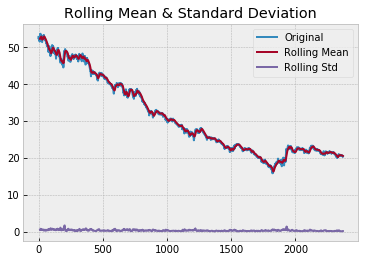

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

xlp_data = stock_data['xlp']
rolling_mean = xlp_data.rolling(window=12,center=False).mean()
rolling_std = xlp_data.rolling(window=12,center=False).std()

orig = plt.plot(xlp_data, label='Original')
mean = plt.plot(rolling_mean, label='Rolling Mean')
std = plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

As seen above, the mearn and standard deviations are not IID. A more explicit stationary test can be done with the Dicky Fuller Test, which tests the null hypothesis of whether a unit root is present in an autoregressive model. 

In [3]:
from statsmodels.tsa.stattools import adfuller

dicky_fuller_data = adfuller(xlp_data, autolag='AIC')
dicky_fuller_output = pd.Series(dicky_fuller_data[0:4],
                      index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dicky_fuller_data[4].items():
    dicky_fuller_output['Critical Value (%s)' % key] = value
print('Results of Dickey-Fuller Test: ', dicky_fuller_output )

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Results of Dickey-Fuller Test:  Test Statistic                   -2.029263
p-value                           0.273891
#Lags Used                        2.000000
Number of Observations Used    2367.000000
Critical Value (1%)              -3.433116
Critical Value (5%)              -2.862762
Critical Value (10%)             -2.567420
dtype: float64


Since the p-value is greater than significance level, the null hypothesis cannot be rejected and therefore autocorrelation exists in our data. 

#### Correlation test

### GARCH Model

In [4]:
ylag = data['xlp'].shift(periods=1).values.astype(float)[2:2370]
y = data['xlp'].values.astype(float)[2:2370]
gdp = data['GDP'].fillna(0)[2:2370]

#### Get Seasonality effects

In [5]:
import numpy as np

seasonalityData = pd.to_datetime(data['Dates'], format='%Y-%m-%d')

monday = [1 if x.weekday() == 0 else 0 for x in seasonalityData]
january = [1 if x.month == 1 else 0 for x in seasonalityData]
endYear = [1 if x.month == 12 else 0 for x in seasonalityData]

seasonalityData = np.column_stack((monday, january, endYear))[2:2370]

In [6]:
modelData = np.column_stack((y, ylag, seasonalityData, gdp))

#### Run maximum likelihood estimation

In [7]:
from scipy import optimize
import statistics as st
import math

def GARCH11_logLFull(param, endog):
    omega, alpha, beta, a, b, monday, jan, end, gmon, gjan, gend, gdp = param
    r = endog[:, 0] - a - b*endog[:, 1] - monday*endog[:, 2] - jan*endog[:, 3] - end*endog[:, 4] - gdp*endog[:, 5]
    n = len(r)
    s = np.ones(n) * 0.01
    s[2] = st.variance(r[0:3])
    for i in range(3, n):
        s[i] = (omega + alpha * r[i - 1] ** 2 + beta * (s[i - 1])) * math.exp(gmon*endog[i, 2] - gjan*endog[i, 3] - gend*endog[i, 4]) # GARCH(1,1) model
    logL = -((-np.log(s) - r ** 2 / s).sum())
    return logL

MLEestimate = optimize.fmin(GARCH11_logLFull,np.array([.5, .5, .5, .5, .5, 0, 0, 0, 0, 0, 0, 0]), args=(modelData,), maxfun=100000, maxiter=10000, full_output=1)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


Optimization terminated successfully.
         Current function value: -4587.852564
         Iterations: 1401
         Function evaluations: 1991


#### Calculate fitted values

In [8]:
def fittedValues(endog, est_params):
    omega, alpha, beta, a, b, monday, jan, end, gmon, gjan, gend, gdp = est_params
    est = a + b * endog[:, 1] + monday*endog[:, 2] + jan*endog[:, 3] + end*endog[:, 4] + gdp*endog[:,5]
    e = endog[:, 0] - est
    n = len(e)
    h = np.ones(n) * 0.01
    h[2] = st.variance(e[0:3])
    for t in range(1, n):
        h[t] = (omega + alpha * e[t - 1] ** 2 + beta * (h[t - 1])) * math.exp(
            gmon * endog[t, 2] - gjan * endog[t, 3] - gend * endog[t, 4])  # GARCH(1,1) model
    z = e * np.sqrt(h)
    return est + z

# initial fitted value estimates
modelEstimate = np.abs(MLEestimate[0])
modelFitted = fittedValues(endog=modelData, est_params=modelEstimate)

##### Plot Resulting Models

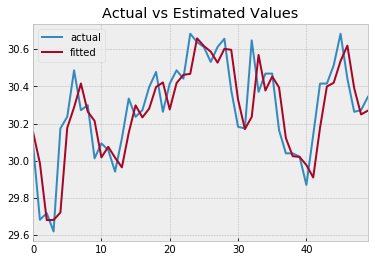

In [9]:
fittedValues = np.column_stack((y[1000:1050], modelFitted[1000:1050]))
graph = pd.DataFrame(fittedValues, columns=['actual', 'fitted'])
graph.plot(title="Actual vs Estimated Values") #colormap='Blues',
        #g.set_axis_bgcolor('k')
plt.show()

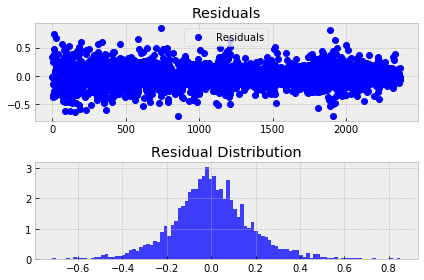

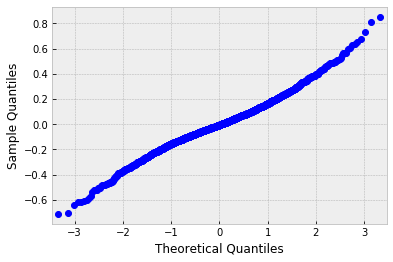

In [10]:
from statsmodels.graphics.gofplots import ProbPlot

residuals = y - modelFitted
plt.subplot(211)
plt.plot(residuals, 'bo', label='Residuals')
plt.legend(loc='best')
plt.title('Residuals')
plt.subplot(212)
plt.hist(residuals, 100, normed=1, facecolor='blue', alpha=0.75)
plt.legend(loc='best')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

probplot = ProbPlot(residuals)
probplot.qqplot()

##### Autocorrelation tests - Ljung-Box Test


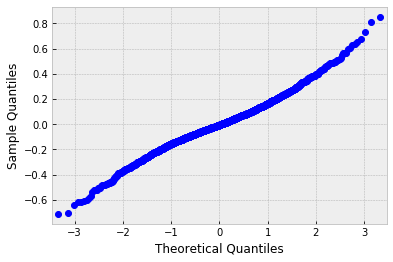

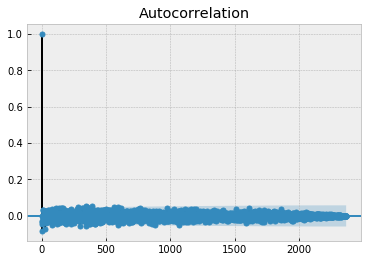

Results of Ljung Box Test and Box Pierce Test: 
Results of Ljung Box Test and Box Pierce Test: 
Ljung-Box Test Statistic         [17.1305107682]
Ljung-Box p-value:           [3.48971782772e-05]
Box Pierce Test Statistic        [17.1088265774]
Box Pierce p-value            [3.5297878135e-05]
dtype: object


In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import ProbPlot

plot_acf(x=residuals)
plt.show()
lbtest = acorr_ljungbox(x=residuals, lags=1, boxpierce=True)
        #lb, lbpval, bp, bppval
print('Results of Ljung Box Test and Box Pierce Test: ')
acfOutput = pd.Series(lbtest[0:4], index=['Ljung-Box Test Statistic', 'Ljung-Box p-value: ',
                                    'Box Pierce Test Statistic', 'Box Pierce p-value'])

print('Results of Ljung Box Test and Box Pierce Test: ')
print(acfOutput)